<a href="https://colab.research.google.com/github/viriya412019005/Projek-KP/blob/main/412019005%2C_412019033%2C_412019038%2C_412019041_MachineLearningTugasKelompok2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
project_name='indonesianfood'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
!ls '/content/gdrive/My Drive/'

'09 Jan 14 2023.gdoc'
'09 Jan 14 2023.pdf'
 412019005.docx
'412019005_VIRIYA DHIKA'
 Adobe
 Badminton
 Businessprocess.drawio
 Classroom
'Colab Notebooks'
'Diagram Konteks.drawio'
'Flowchart waterfall 4.drawio'
'FORM PENILAIAN KERJA PRAKTEK_PROGRAM MBKM BKP MAGANG (1).gdoc'
 FormulirPermohonanSuratPengantar_ViriyaDhika_412019005.docx.jpg
 IMG_20220713_172949.jpg
 KTP_Belakang_VIRIYADHIKA.jpg
 KTP_Depan_VIRIYADHIKA.jpg
 KTP_ViriyaDhika.pdf
'Machine Learing 6PITA'
'Machine Learning 6PITA'
 Magang
'Metodologi Penelitian'
'Pemograman Piranti Bergerak I'
'Pemrograman Web III'
'Projek KP'
'Semester 6'
 Sertifikat
'Sistem Pendukung Keputusan'
 Skripsi
 UAS_SPK_TEAM6
 Umbu
'Untitled Diagram.drawio'


In [5]:
PATH = "/content/gdrive/MyDrive/Machine Learing 6PITA/traindata/indonesiafood"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# make sure my GPU is detected.
print(device)


cuda:0


In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [7]:
image_datasets = {
    x: datasets.ImageFolder(os.path.join(PATH, x),
                            data_transforms[x]) for x in ['train', 'valid']
}
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], 
                                   batch_size=32,
                                   shuffle=True, 
                                ) for x in ['train', 'valid']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}

In [8]:
class_names = image_datasets['train'].classes
print(class_names)


['bakso', 'batagor', 'mieayam']


In [9]:
# create a function image show

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

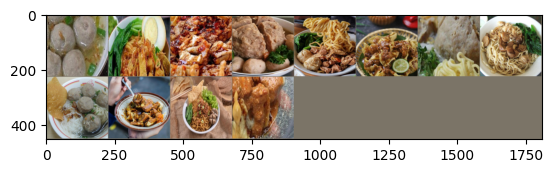

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Valid Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
model_1 = models.resnet18(pretrained=True)
num_ftrs = model_1.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_1.fc = nn.Linear(num_ftrs, len(class_names))

model_1 = model_1.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_sgd = optim.SGD(model_1.parameters(), lr=0.001, momentum=0.9)
optimizer_adam = optim.Adam(model_1.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_adam, step_size=7, gamma=0.1)

model_resnetft = train_model(model_1, criterion, optimizer_adam, exp_lr_scheduler,
                       num_epochs=15)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]


Epoch 0/14
----------
train Loss: 1.2738 Acc: 0.2500
valid Loss: 1.6833 Acc: 0.4444

Epoch 1/14
----------
train Loss: 0.2557 Acc: 0.9167
valid Loss: 2.0461 Acc: 0.4444

Epoch 2/14
----------
train Loss: 0.2058 Acc: 1.0000
valid Loss: 2.3979 Acc: 0.4444

Epoch 3/14
----------
train Loss: 0.0112 Acc: 1.0000
valid Loss: 6.4415 Acc: 0.3333

Epoch 4/14
----------
train Loss: 0.0271 Acc: 1.0000
valid Loss: 7.9378 Acc: 0.3333

Epoch 5/14
----------
train Loss: 0.1400 Acc: 0.9167
valid Loss: 6.4132 Acc: 0.3333

Epoch 6/14
----------
train Loss: 0.0063 Acc: 1.0000
valid Loss: 5.0947 Acc: 0.3333

Epoch 7/14
----------
train Loss: 0.0226 Acc: 1.0000
valid Loss: 4.4975 Acc: 0.3333

Epoch 8/14
----------
train Loss: 0.0081 Acc: 1.0000
valid Loss: 4.0194 Acc: 0.3333

Epoch 9/14
----------
train Loss: 0.0053 Acc: 1.0000
valid Loss: 3.6008 Acc: 0.3333

Epoch 10/14
----------
train Loss: 0.1015 Acc: 0.9167
valid Loss: 2.9930 Acc: 0.3333

Epoch 11/14
----------
train Loss: 0.0189 Acc: 1.0000
valid Loss

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

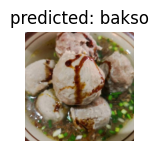

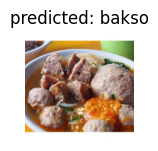

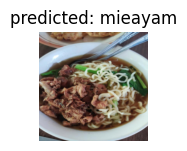

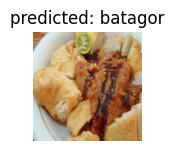

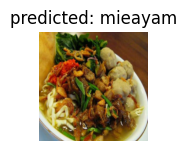

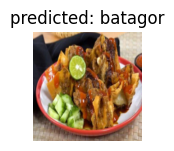

In [14]:
 # Visualize model
 visualize_model(model_1)